# Introduction

The dataset used will be Fashion-MNIST. 

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (Fashion MNIST, 2022)

The deep learning workflow: 7-step workflow
1. Define the problem and collect samples and labels 
2. Choose the success criterion and monitoring metrics.
3. Choose a validation protocol.
4. Prepare data
5. Develop a first underfitting model with statistical power.
6. Develop a larger overfitting model
7. Regularise the overfitting model and tune hyperparameters based on performance on validation data. 

# Methodology

### The Problem

The MNIST dataset contains 70,000 images of 10 types of clothing (0-9). Each image is a 28 × 28 × 1 array of floating-point numbers representing grayscale intensities ranging from 0 (black) to 1 (white). The target data consists of one-hot binary vectors of size 10, corresponding to the clothing item classification categories 0 through 9, as can be seen below. (Fashion MNIST, 2022)

0 - T-shirt/top

1 - Trouser

2 - Pullover

3 - Dress

4 - Coat

5 - Sandal

6 - Shirt

7 - Sneaker

8 - Bag

9 - Ankle boot


The problem is classifying the correct clothing category from a greyscale image based on different types of that clothing classification. The type of problem is a single label multiclass classification. 

Hypotheses:
- Outputs (correct labelling of the fashion item) can be predicted from the inputs (greyscale images).
- The available data is sufficiently informative to learn the relationship between inputs and outputs.

### Success criterion and monitoring metrics

The success criterion and monitoring metrics will be accuracy. Accuracy is the fraction of predictions our model gets correct. It is calculated by the (number of correct predictions)/(total number of predictions). Accuracy will thus be a floating-point value between 0 and 1. The higher the accuracy, the more correct predictions there are.

### Validation Protocol

To evaluate model performance, hold-out validation will be used, as we assume that the dataset has sufficient information. Hold-out validation is the process of splitting off part of the training set and using it for validation. In this case, in our fashion-mnist dataset, we have a total of 70,000 data. Of this 70,000, 10,000 will be used as the test set, while the rest (60,000) will be used as the training data. Of this 60,000 training dataset, we will further split off into 50,000 as partial training data and the other 10,000 as validation data. After the process of splitting, we will first train the model using the partial training data and test it on the validation data. After sufficient rounds of tuning the hyperparameters and retraining the model, we will finally retrain a fresh model on all the training data (60,000) and evaluate on the unseen test set. 

### Prepare data

First, we load the fashion_mnist dataset. Then, we reshape the image data to 1D tensors of (60000, 784) and (10000, 784), where there are 60000 training images and 10000 test images with grayscale values. Next, we rescale them to be from [0,1]. As for the image labels (targets), which are numbers from 0-9, we one-hot encode them using the to_categorical method. Then, we split the 60000 train images into 50000 and 10000, to be used as partial training dataset and validation dataset.

#### Import libraries

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# load
from tensorflow.keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# preprocess
# flattens 28 x 28 vector into 784 elements (1D tensor)
train_images = train_images.reshape((60000, 28 * 28))
test_images = test_images.reshape((10000, 28 * 28))

# cast as floats and rescale to [0,1]
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# slice training data into validation and partial training
validation_images = train_images[:10000]
validation_labels = train_labels[:10000]
partial_train_images = train_images[10000:]
partial_train_labels = train_labels[10000:]

### Underfitting model

Before building an underfitting model, we must decide on the last-layer activation, loss function and the optimisation configuration. Since the problem type is multiclass, single-label classification, we can reference the table taken from DLWP which specifies the right last-layer activation and loss function as can be seen below. The adam optimizer can be used.

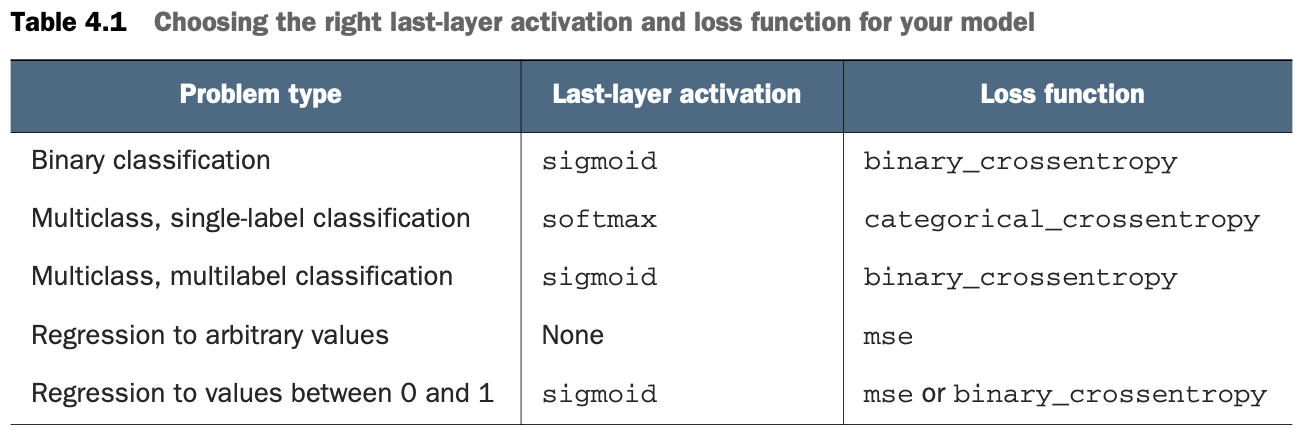

In [6]:
# Underfitting
import tensorflow
# build
from tensorflow.keras import models, layers
base_model = models.Sequential()
base_model.add(layers.Dense(10, activation='softmax'))

base_model.compile(optimizer=tensorflow.keras.optimizers.Adam(0.001),
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
base_history = base_model.fit(partial_train_images, partial_train_labels, epochs=2, batch_size=32, validation_data=(validation_images, validation_labels))

Epoch 1/2


2022-03-10 18:04:16.556244: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1563/1563 [==============================] - 2s 896us/step - loss: 0.6205 - accuracy: 0.7879 - val_loss: 0.5183 - val_accuracy: 0.8240
Epoch 2/2
1563/1563 [==============================] - 1s 800us/step - loss: 0.4732 - accuracy: 0.8384 - val_loss: 0.4587 - val_accuracy: 0.8416


In [7]:
base_history_dict = base_history.history
base_history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Training and Validation Accuracy Graph

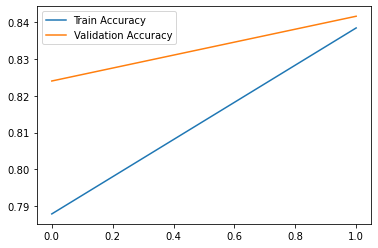

In [8]:
plt.plot(base_history_dict['accuracy'], label="Train Accuracy") # blue 
plt.plot(base_history_dict['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

Here, we have used a single layer of softmax activation to achieve an underfitting model.
The graph above shows underfitting, as it lowers the loss on both training and validation data. Additionally, it beats a baseline model as it has a higher accuracy than 0.1 (probability of a correct blind guess). 

### Overfitting model

To build an overfitting model, we can add layers, make the layers bigger, or train for more epochs etc. Here, we implement all three: add 3 more layers and set epochs to 30, as well as use the rmsprop optimiser.

In [10]:
# Overfitting

# build
from tensorflow.keras import models, layers
overfit_model = models.Sequential()
overfit_model.add(layers.Dense(64, activation='relu', input_shape=(28 * 28, )))
overfit_model.add(layers.Dense(64, activation='relu'))
overfit_model.add(layers.Dense(64, activation='relu'))
overfit_model.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
overfit_model.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
overfit_history = overfit_model.fit(partial_train_images, partial_train_labels, epochs=30, batch_size=128, validation_data=(validation_images, validation_labels))

Epoch 1/30
391/391 [==============================] - 1s 2ms/step - loss: 0.6348 - accuracy: 0.7738 - val_loss: 0.4892 - val_accuracy: 0.8261
Epoch 2/30
391/391 [==============================] - 1s 1ms/step - loss: 0.4309 - accuracy: 0.8432 - val_loss: 0.4130 - val_accuracy: 0.8505
Epoch 3/30
391/391 [==============================] - 1s 1ms/step - loss: 0.3828 - accuracy: 0.8597 - val_loss: 0.4025 - val_accuracy: 0.8570
Epoch 4/30
391/391 [==============================] - 1s 1ms/step - loss: 0.3500 - accuracy: 0.8714 - val_loss: 0.3657 - val_accuracy: 0.8665
Epoch 5/30
391/391 [==============================] - 1s 2ms/step - loss: 0.3306 - accuracy: 0.8785 - val_loss: 0.3427 - val_accuracy: 0.8730
Epoch 6/30
391/391 [==============================] - 1s 2ms/step - loss: 0.3142 - accuracy: 0.8838 - val_loss: 0.3473 - val_accuracy: 0.8745
Epoch 7/30
391/391 [==============================] - 1s 1ms/step - loss: 0.3032 - accuracy: 0.8871 - val_loss: 0.3305 - val_accuracy: 0.8774
Epoch 

#### Training and Validation Accuracy Graph

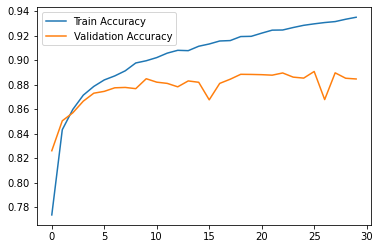

In [11]:
import matplotlib.pyplot as plt

plt.plot(overfit_history.history['accuracy'], label="Train Accuracy") # blue 
plt.plot(overfit_history.history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

The graph shows overfitting. 

The Validation Accuracy graph performs better than the Train Accuracy graph, experiencing a higher accuracy at the beginning. However, from around 3 epochs onwards, the validation accuracy starts having a larger disparity of accuracy than training accuracy. 

From the graph, we can see that overfitting starts after the Validation Accuracy graph intersects with the Train Accuracy graph, at 3 epochs. We should stop training as soon as overfitting starts. The optimal number of epochs can be used to regularise the model and reduce overfitting.

### Regularisation and tuning hyperparameters

Regularisation is the process of reducing the error by fitting a model appropriately on the given training set and avoid overfitting. (REGULARIZATION: An important concept in Machine Learning, 2022)

Since optimal epoch is 3 as computed above, we first set the epoch to be 3 to reduce overfitting and observe the performance from there.

#### Model 1

In [13]:
# build
from tensorflow.keras import models, layers
model1 = models.Sequential()
model1.add(layers.Dense(64, activation='relu', input_shape=(28 * 28, )))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
model1.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
model1_history = model1.fit(partial_train_images, partial_train_labels, epochs=3, batch_size=128, validation_data=(validation_images, validation_labels))

Epoch 1/3
391/391 [==============================] - 1s 2ms/step - loss: 0.6269 - accuracy: 0.7719 - val_loss: 0.4730 - val_accuracy: 0.8325
Epoch 2/3
391/391 [==============================] - 1s 2ms/step - loss: 0.4353 - accuracy: 0.8433 - val_loss: 0.4496 - val_accuracy: 0.8350
Epoch 3/3
391/391 [==============================] - 1s 1ms/step - loss: 0.3853 - accuracy: 0.8569 - val_loss: 0.3950 - val_accuracy: 0.8551


#### Training and Validation Accuracy Graph

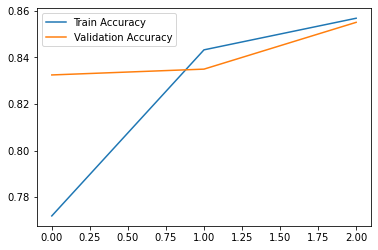

In [14]:
import matplotlib.pyplot as plt

plt.plot(model1_history.history['accuracy'], label="Train Accuracy") # blue 
plt.plot(model1_history.history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

Here, we can see that our model has reduced overfitting, compared to when we set number of epochs to be 30. However, there is still overfitting happening. So we reduce the number of layers by 1.

#### Model 2

We remove a layer.

In [15]:
# build
from tensorflow.keras import models, layers
model2 = models.Sequential()
model2.add(layers.Dense(64, activation='relu', input_shape=(28 * 28, )))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
model2_history = model2.fit(partial_train_images, partial_train_labels, epochs=3, batch_size=128, validation_data=(validation_images, validation_labels))

Epoch 1/3
391/391 [==============================] - 1s 2ms/step - loss: 0.6257 - accuracy: 0.7763 - val_loss: 0.4675 - val_accuracy: 0.8335
Epoch 2/3
391/391 [==============================] - 1s 1ms/step - loss: 0.4271 - accuracy: 0.8471 - val_loss: 0.3983 - val_accuracy: 0.8573
Epoch 3/3
391/391 [==============================] - 1s 1ms/step - loss: 0.3800 - accuracy: 0.8625 - val_loss: 0.4012 - val_accuracy: 0.8522


#### Training and Validation Accuracy Graph

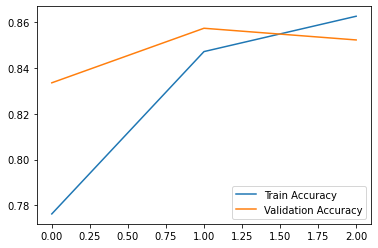

In [16]:
import matplotlib.pyplot as plt

plt.plot(model2_history.history['accuracy'], label="Train Accuracy") # blue 
plt.plot(model2_history.history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

Here, we can see that our model has successfully reduced overfitting. However, there is still potential for improvement. So we reduce the number units in the layers to regularise our model.

#### Model 3

Change the number of units in the layers

In [17]:
# build
from tensorflow.keras import models, layers
model3 = models.Sequential()
model3.add(layers.Dense(32, activation='relu', input_shape=(28 * 28, )))
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
model3.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
model3_history = model3.fit(partial_train_images, partial_train_labels, epochs=3, batch_size=128, validation_data=(validation_images, validation_labels))

Epoch 1/3
391/391 [==============================] - 1s 1ms/step - loss: 0.6772 - accuracy: 0.7685 - val_loss: 0.5194 - val_accuracy: 0.8105
Epoch 2/3
391/391 [==============================] - 0s 1ms/step - loss: 0.4641 - accuracy: 0.8367 - val_loss: 0.4425 - val_accuracy: 0.8437
Epoch 3/3
391/391 [==============================] - 0s 1ms/step - loss: 0.4220 - accuracy: 0.8474 - val_loss: 0.4459 - val_accuracy: 0.8378


#### Training and Validation Accuracy Graph

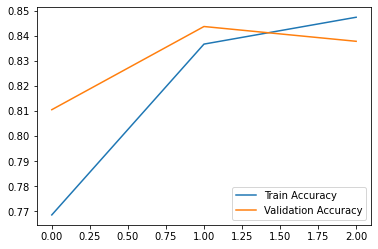

In [18]:
import matplotlib.pyplot as plt

plt.plot(model3_history.history['accuracy'], label="Train Accuracy") # blue 
plt.plot(model3_history.history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

Since there was no significant change in regularising after tuning the hyperparameters, we can introduce L2 regularisation and observe. 

#### Model 4

Introduce L2 regularisation

In [23]:
import tensorflow as tf
from tensorflow.keras import models, layers
model4 = models.Sequential()
model4.add(layers.Dense(32, activation='relu', input_shape=(28 * 28, ), kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
model4.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
model4_history = model4.fit(partial_train_images, partial_train_labels, epochs=3, batch_size=128, validation_data=(validation_images, validation_labels))

Epoch 1/3
391/391 [==============================] - 1s 1ms/step - loss: 0.7454 - accuracy: 0.7668 - val_loss: 0.5993 - val_accuracy: 0.8037
Epoch 2/3
391/391 [==============================] - 0s 1ms/step - loss: 0.5375 - accuracy: 0.8330 - val_loss: 0.5186 - val_accuracy: 0.8382
Epoch 3/3
391/391 [==============================] - 0s 1ms/step - loss: 0.4989 - accuracy: 0.8409 - val_loss: 0.5274 - val_accuracy: 0.8272


#### Training and Validation Accuracy Graph

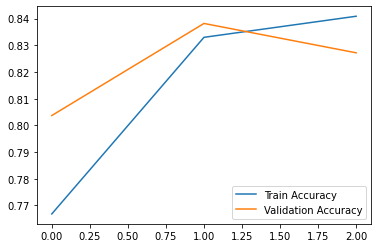

In [24]:
import matplotlib.pyplot as plt

plt.plot(model4_history.history['accuracy'], label="Train Accuracy") # blue 
plt.plot(model4_history.history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

From introducing L2 regularisation, there was still no significant change, so the problem may perhaps lie with the hyperparameters. We can try to find a good fit for our model.

#### Model 5

Here we've tried adding another layer of 32 units.

In [29]:
import tensorflow as tf
from tensorflow.keras import models, layers
model5 = models.Sequential()
model5.add(layers.Dense(32, activation='relu', input_shape=(28 * 28, ), kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model5.add(layers.Dense(32, activation='relu'))
model5.add(layers.Dense(32, activation='relu'))
model5.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
model5.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
model5_history = model5.fit(partial_train_images, partial_train_labels, epochs=3, batch_size=128, validation_data=(validation_images, validation_labels))

Epoch 1/3
391/391 [==============================] - 1s 2ms/step - loss: 0.7475 - accuracy: 0.7572 - val_loss: 0.5460 - val_accuracy: 0.8264
Epoch 2/3
391/391 [==============================] - 0s 1ms/step - loss: 0.5281 - accuracy: 0.8320 - val_loss: 0.4976 - val_accuracy: 0.8430
Epoch 3/3
391/391 [==============================] - 0s 1ms/step - loss: 0.4818 - accuracy: 0.8447 - val_loss: 0.5040 - val_accuracy: 0.8367


#### Training and Validation Accuracy Graph

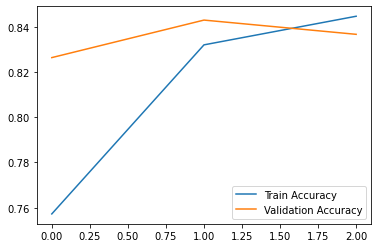

In [30]:
import matplotlib.pyplot as plt

plt.plot(model5_history.history['accuracy'], label="Train Accuracy") # blue 
plt.plot(model5_history.history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

We notice that the accuracy increased slightly, so we continue to tune the hyperparameters whilst maintaining the number of layers.

#### Model 6

Here, we try changing the unit of the first layer. 

In [63]:
import tensorflow as tf
from tensorflow.keras import models, layers
model6 = models.Sequential()
model6.add(layers.Dense(64, activation='relu', input_shape=(28 * 28, ), kernel_regularizer=tf.keras.regularizers.L2(0.002)))
model6.add(layers.Dense(32, activation='relu'))
model6.add(layers.Dense(32, activation='relu'))
model6.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
model6.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
model6_history = model6.fit(partial_train_images, partial_train_labels, epochs=5, batch_size=128, validation_data=(validation_images, validation_labels))

Epoch 1/5
391/391 [==============================] - 1s 2ms/step - loss: 0.8307 - accuracy: 0.7588 - val_loss: 0.6659 - val_accuracy: 0.8089
Epoch 2/5
391/391 [==============================] - 1s 1ms/step - loss: 0.5882 - accuracy: 0.8264 - val_loss: 0.5497 - val_accuracy: 0.8330
Epoch 3/5
391/391 [==============================] - 1s 1ms/step - loss: 0.5220 - accuracy: 0.8380 - val_loss: 0.5266 - val_accuracy: 0.8349
Epoch 4/5
391/391 [==============================] - 1s 1ms/step - loss: 0.4849 - accuracy: 0.8490 - val_loss: 0.4866 - val_accuracy: 0.8466
Epoch 5/5
391/391 [==============================] - 1s 1ms/step - loss: 0.4635 - accuracy: 0.8540 - val_loss: 0.4460 - val_accuracy: 0.8599


#### Training and Validation Accuracy Graph

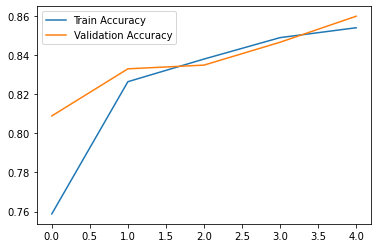

In [64]:
import matplotlib.pyplot as plt

plt.plot(model6_history.history['accuracy'], label="Train Accuracy") # blue 
plt.plot(model6_history.history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

Here, we are finally nearing a good fit. We continue to tune the hyperparameters to achieve a good fit.

#### Model 7

Reduce the units of the hidden layers.

In [81]:
import tensorflow as tf
from tensorflow.keras import models, layers
model7 = models.Sequential()
model7.add(layers.Dense(64, activation='relu', input_shape=(28 * 28, ), kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model7.add(layers.Dense(16, activation='relu'))
model7.add(layers.Dense(16, activation='relu'))
model7.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
model7.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
model7_history = model7.fit(partial_train_images, partial_train_labels, epochs=5, batch_size=128, validation_data=(validation_images, validation_labels))

Epoch 1/5
391/391 [==============================] - 1s 2ms/step - loss: 0.8600 - accuracy: 0.7331 - val_loss: 0.5889 - val_accuracy: 0.8250
Epoch 2/5
391/391 [==============================] - 1s 1ms/step - loss: 0.5640 - accuracy: 0.8297 - val_loss: 0.5468 - val_accuracy: 0.8348
Epoch 3/5
391/391 [==============================] - 1s 1ms/step - loss: 0.5119 - accuracy: 0.8416 - val_loss: 0.4992 - val_accuracy: 0.8422
Epoch 4/5
391/391 [==============================] - 1s 1ms/step - loss: 0.4776 - accuracy: 0.8529 - val_loss: 0.4591 - val_accuracy: 0.8550
Epoch 5/5
391/391 [==============================] - 1s 1ms/step - loss: 0.4564 - accuracy: 0.8565 - val_loss: 0.4470 - val_accuracy: 0.8592


#### Training and Validation Accuracy Graph

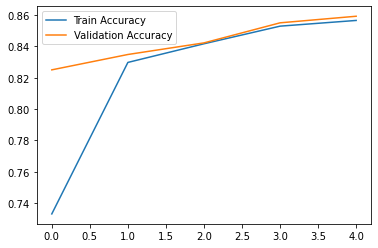

In [82]:
import matplotlib.pyplot as plt

plt.plot(model7_history.history['accuracy'], label="Train Accuracy") # blue 
plt.plot(model7_history.history['val_accuracy'], label="Validation Accuracy") # orange
plt.legend()

Now, we have achieved a good fitting and are satisfied with our regularised model. We can proceed to instantiate a new model and train this model on the entire training set (partial training and validation sets combined) and evaluate it on the test set. 

#### Evaluate on test set

In [84]:
import tensorflow as tf
from tensorflow.keras import models, layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(28 * 28, ), kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

tf.random.set_seed(3)
model.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

# train
history = model.fit(train_images, train_labels, epochs=5, batch_size=128)

test_loss, test_acc = model.evaluate(test_images, test_labels)

Epoch 1/5
469/469 [==============================] - 1s 1ms/step - loss: 0.8026 - accuracy: 0.7523
Epoch 2/5
469/469 [==============================] - 1s 1ms/step - loss: 0.5467 - accuracy: 0.8336
Epoch 3/5
469/469 [==============================] - 1s 1ms/step - loss: 0.5029 - accuracy: 0.8453
Epoch 4/5
469/469 [==============================] - 1s 1ms/step - loss: 0.4753 - accuracy: 0.8526
Epoch 5/5
313/313 [==============================] - 0s 767us/step - loss: 0.4999 - accuracy: 0.8398


In [85]:
print("Test accuracy:",test_acc)
print("Test loss:",test_loss)

Test accuracy: 0.8398000001907349
Test loss: 0.49994179606437683


# Results

After regularising and tuning the hyperparameters, the model is trained using the whole training dataset and evaluated on the test dataset. The results show that the accuracy generated on evaluation is lower and the loss generated on evaluation is higher than when training the model, albeit it being a slight difference.

For statistical comparison, the evaluation accuracy is 0.84 and loss is 0.5, while the training accuracy is 0.85 and loss is 0.45. 

# Conclusion

In conclusion, the fashion-mnist dataset was split into training and test sets, of which the training set was then further split into partial training and validation sets (hold-out validation). 
The model was first trained using the partial training dataset and validated using the validation dataset. 
We then start by developing an underfitting model, with a single layer of softmax activation, and generated an accuracy of 0.84. 
Then, the next step is to develop an overfitting model, which we did with additional layers of relu activation and increased the number of epochs. From our overfitting model, we can deduce the optimal number of epochs, which was observed to be 3. This information was then used to regularise our overfitting model and tune our hyperparameters. 
After setting epochs to 3, there was still room for improvement, thus, alternative methods were used to further reduce overfitting, such as applying L2 regularisation and tuning the hyperparameters. L2 regularisation was set to 0.001 after much experimentation and batch size to 128, along with decreased layer units, which further regularised our model. Now that we have developed a satisfactory model, we can instantiate a new model and train it using the whole training dataset (partial training and validation sets) and evaluate our model on the test data. After evaluation, it turns out that performance on the train set is relatively better than the performance measured on the test set, which can be seen under Results. 

# References

1. Kaggle.com. 2022. Fashion MNIST. [online] Available at: <https://www.kaggle.com/zalando-research/fashionmnist> [Accessed 27 February 2022].

2. Medium. 2022. REGULARIZATION: An important concept in Machine Learning. [online] Available at: <https://towardsdatascience.com/regularization-an-important-concept-in-machine-learning-5891628907ea> [Accessed 27 February 2022].

3. Coursera Labs MNIST.ipynb